# 2. Solving a Simple Linear Regression Model with a Mock Dataset, using Gradient Descent

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (23/01/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression

### Mock dataset generation

As in notebook 1, will be skipped.

In [2]:
# All helper functions
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this will return the price in millions of SGD.
    return round((100000 + 14373*surface)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def generate_datasets(n_points, min_surf, max_surf):
    x = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    y = np.array([price(i) for i in x])
    return x, y

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
min_surf = 40
max_surf = 150
np.random.seed(27)
n_points = 50
inputs, outputs = generate_datasets(n_points, min_surf, max_surf)
print(inputs)
print(outputs)

[ 86.83 129.6  120.89 135.48  82.17 147.74 138.25  63.07 121.6  112.95
 137.55 134.38 122.42 135.72  60.54  75.81  81.02 127.31  56.62  58.69
  48.93  73.57 126.16  57.92  47.77 117.12  59.91 105.88  85.68  96.49
  64.27 119.81 133.44 142.18 120.95  92.42  94.22 105.4   48.36  52.92
 146.31 104.17  50.17  41.5  132.06 140.63 117.5   82.57 117.63 141.56]
[1.290893 2.034977 1.84501  2.201767 1.389632 2.218678 2.127228 0.959054
 2.029469 1.623609 2.111638 2.09194  2.012386 1.89553  1.004256 1.250228
 1.368325 1.830127 1.000719 0.906513 0.867629 1.065907 1.979544 1.001403
 0.796199 1.771816 0.867878 1.587176 1.25434  1.40047  1.002361 1.9972
 1.894479 2.293443 1.823577 1.340533 1.358613 1.602167 0.750759 0.863093
 2.30035  1.741468 0.7448   0.763732 2.093772 1.986868 1.90702  1.289541
 1.86578  2.231851]


### Linear Regression

As explained in notebook 1.

Linear regression is a model, which assumes that there is a linear relationship between inputs $ x $ and outputs $ y $. It therefore consists of two parameters $ (a, b) $, to be chosen, which will connect any input $ x_i $ to its respective output $ y_i $, with the equation:

$$ y_i \approx a x_i + b $$

Below, we define the **linreg_matplotlib()** function, which produces a list of values to be used for display later, to represent the linear function $ f(x) = ax + b $ in matplotlib, for any parameters a and b.

In [4]:
# Linear regression has two trainable parameters (a and b).
# Other parameters, like min_surf, max_surf, n_points will
# help get points for the upcoming matplotlib displays.
def linreg_matplotlib(a, b, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = a*x + b
    return x, y

### Loss function

As explained in Notebook 1.

In order to measure the quality of the fit for each model, and evaluate whether the parameters $ (a, b) $ used for the linear regression are good choices or not, we will use a loss function, namely the mean square error  $ L(a, b, x, y) $:

$$ L(a, b, x, y) = \frac{1}{N} \sum_{i=1}^N \left((a x_i + b) - y_i\right)^2 $$

With $ N $ being the number of points in the dataset (i.e. the value in the variable *n_points*).

As a rule of thumb, the lower the value of this loss function, the better the model fits the data.

We implement the loss function below, as the function **loss_mse()**.

In [5]:
# Mean square error as a loss function
# Displaying loss using exponential notation (XXXe-YYY)
def loss_mse(a, b, x, y):
    val =  np.sum((y - (a*x + b))**2)/x.shape[0]
    return '{:.2e}'.format(val)

Below, we provide a full display with dataset entries, the three linear regressions and their loss values.

### Recap: Finding the optimal linear regression parameters, analytically

As explained in Notebook 1.

The best values $ (a^* , b^*) $ to be used for $ (a, b) $ can be found by solving the following optimization problem.

For any dataset of given inputs $ x = (x_i)_{i \in \{1, 2, ..., N\}} $ and outputs $ y = (y_i)_{i \in \{1, 2, ..., N\}} $, the best values $ (a^* , b^*) $ are defined as:

$$ (a^* , b^*) = \arg\min_{(a, b)} \left[ L(a, b, x, y) \right] $$

Or, equivalently:

$$ (a^* , b^*) = \arg\min_{(a, b)} \left[ \frac{1}{N} \sum_{i=1}^N \left((a x_i + b) - y_i\right)^2 \right] $$

Let us define the matrix notations, below:

$$ W = \begin{pmatrix} b \\ a \end{pmatrix}, $$

$$ X = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{pmatrix}, $$

$$ Y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{pmatrix}, $$

Using these notations, we can prove that the optimal values $ (a^*, b^*) $, or equivalently $ W^* $, can be calculated as

$$ W^* = (X^T X)^{-1} X^T Y $$

(**Proof:** is out of scope, but for those of you who are curious, have a look at these lectures notes, https://people.cs.pitt.edu/~milos/courses/cs2750-Spring03/lectures/class6.pdf.)

In [6]:
# Defining W_star according to our formula
X = np.array([[1, x_i] for x_i in inputs])
XT = np.transpose(X)
Y = np.array([[y_i] for y_i in outputs])
W_star = np.matmul(np.linalg.inv(np.matmul(XT,X)), np.matmul(XT,Y))
print(W_star)
b_star, a_star = W_star[0, 0], W_star[1, 0]
print("Optimal a_star value: ", a_star)
print("The value we used for a in the mock dataset generation: ", 14373/1000000)
print("Optimal b_star value: ", b_star)
print("The value we used for b in the mock dataset generation: ", 100000/1000000)

[[0.06941742]
 [0.01484444]]
Optimal a_star value:  0.014844435285058159
The value we used for a in the mock dataset generation:  0.014373
Optimal b_star value:  0.06941742189819247
The value we used for b in the mock dataset generation:  0.1


As in Notebook 1, we provide a display, showing the optimal linear regression model, in dashed magenta, below.

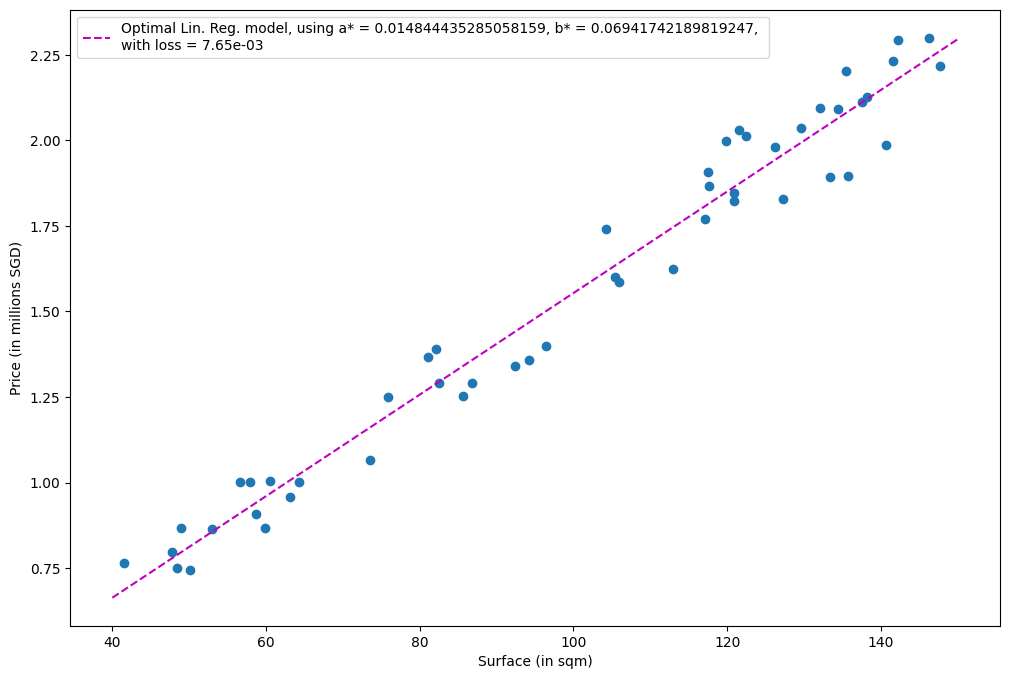

In [7]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Optimal linreg (calculated using the W_star formula)
linreg_dataset1_inputs, linreg_dataset1_outputs = linreg_matplotlib(a_star, b_star, min_surf, max_surf, n_points)
loss1 = loss_mse(a_star, b_star, inputs, outputs)
legend1 = "Optimal Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_star, b_star, loss1)
plt.plot(linreg_dataset1_inputs, linreg_dataset1_outputs, 'm--', label = legend1)

# Display
plt.legend(loc = 'best')
plt.show()

### Using Gradient Descent to Compute the Optimal Linear Regression Parameters

The formula $ W^* = (X^T X)^{-1} X^T Y $, while being the correct analytical one, suffers from one major issue.

It relies on huge matrices $ X $ and $ Y $, and requires inverting a matrix, which can prove to be costly, especially when the number of entries in the dataset, *n_points*, grows large.

As such, it is often preferable to find a heuristic way to approximate the $ W^* $ parameters.

The typical approach consists of using gradient descent on the loss function $ L(a, b, x, y) = \frac{1}{N} \sum_{i=1}^N \left((a x_i + b) - y_i\right)^2 $ we defined earlier, to find the optimal parameters for the linear regression model.

Gradient descent, is therefore a non-analytical way to solve the optimization problem we defined earlier, i.e.: 

$$ (a^* , b^*) = \arg\min_{(a, b)} \left[ L(a, b, x, y) \right]. $$

For this loss function, we have the following partial derivatives, with respect to $ a $ and $ b $:
$$ D_a = \frac{\partial L}{\partial a}  = \frac{-2}{N} \sum_{i = 1}^{N} x_i (y_i - (a x_i + b)) $$
$$ D_b = \frac{\partial L}{\partial b}  = \frac{-2}{N} \sum_{i = 1}^{N} (y_i - (a x_i + b)) $$

Our update rules for the gradient descent are therefore defined below, with $ \alpha $ being the learning rate for the gradient descent, a parameter to be decided manually, later.
$$ a \leftarrow a - \alpha D_a $$
$$ b \leftarrow b - \alpha D_b $$

We will repeat these iterations, until a convergence is observed on both $ a $ and $ b $, and then return their final values, claiming that they are close enough to the analytical best values $ a^* $ and $ b^* $.

Our gradient descent approximator function, **gradient_descent_linreg()**, is implemented below.

In [8]:
def gradient_descent_linreg(a_0, b_0, x, y, alpha = 1e-5, delta = 1e-5, max_count = 1000):
    # Define the initial values of a and b as a_0 and b_0
    a, b = a_0, b_0
    # Define N as the number of elements in the dataset
    N = len(x)
    # Keep track of how much a and b changed on each iteration
    change = float("Inf")
    # Counter as safety to prevent infinite looping
    counter = 0
    # List of losses, to be used for display later
    losses = []
    while change > delta:
        # Helper to visualize iterations of while loop
        print("-----")
        # Use gradident descent update rules for a and b
        D_a = -2/N*(sum([x_i*(y_i - (a*x_i + b)) for x_i, y_i in zip(x, y)]))
        D_b = -2/N*(sum([(y_i - (a*x_i + b)) for x_i, y_i in zip(x, y)]))
        a = a - alpha*D_a
        b = b - alpha*D_b
        print("Gradients: ", D_a, D_b)
        print("New values for (a, b): ", a, b)
        # Compute change
        change = max(abs(alpha*D_a), abs(alpha*D_b))
        print("Change: ", change)
        # COmpute and display current loss
        loss = loss_mse(a, b, x, y)
        losses.append(float(loss))
        print("Loss: ", loss)
        # Counter update, will break if iterations number exceeds max_count,
        # to prevent gradient descent from going indefinitely.
        # (Just a safety measure, for good practice, we would definitely prefer to see
        # the while loop break "naturally", because change eventually fell under the threshold stop.)
        counter += 1
        if(counter > max_count):
            print("Maximal number of iterations reached.")
            break
    return a, b, losses

We then run the gradient descent, with the parameters $ \alpha = 1e-5 $ and $ delta = 1e-6 $.

Feel free to try different values to see how it goes!

In [9]:
a_gd, b_gd, losses = gradient_descent_linreg(a_0 = 0, b_0 = 0, x = inputs, y = outputs, alpha = 1e-5, delta = 1e-6)

-----
Gradients:  -342.3996226384001 -3.105429920000001
New values for (a, b):  0.0034239962263840013 3.105429920000001e-05
Change:  0.0034239962263840013
Loss:  1.61e+00
-----
Gradients:  -266.6158814454798 -2.421097231142153
New values for (a, b):  0.006090155040838799 5.526527151142155e-05
Change:  0.002666158814454798
Loss:  9.82e-01
-----
Gradients:  -207.60544547655167 -1.8882287012275232
New values for (a, b):  0.008166209495604315 7.414755852369678e-05
Change:  0.002076054454765517
Loss:  5.99e-01
-----
Gradients:  -161.6558592140118 -1.4733005885082109
New values for (a, b):  0.009782768087744434 8.888056440877889e-05
Change:  0.0016165585921401181
Loss:  3.66e-01
-----
Gradients:  -125.87634931834438 -1.1502090007150434
New values for (a, b):  0.011041531580927877 0.00010038265441592931
Change:  0.001258763493183444
Loss:  2.25e-01
-----
Gradients:  -98.01596073814797 -0.8986276509816881
New values for (a, b):  0.012021691188309357 0.0001093689309257462
Change:  0.00098015960

Below, we display how the model MSE loss evolved over each iteration of the gradient descent.

We can see that the MSE loss eventually converges to a low value (8.12e-3 or so), which is the sign of a convergence for the gradient descent algorithm.

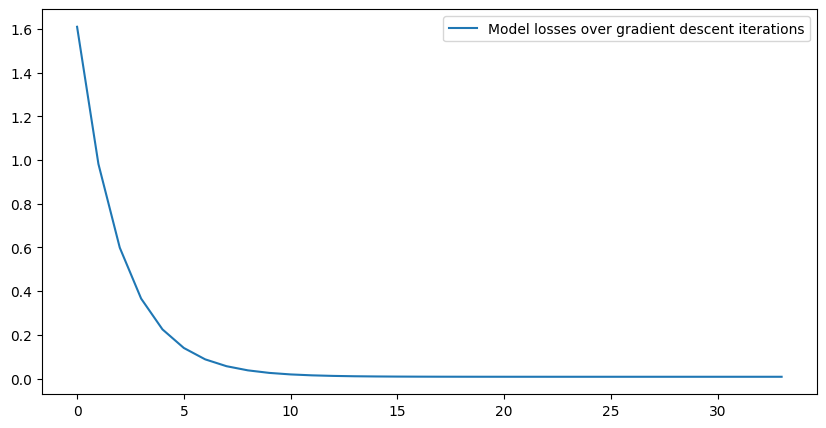

In [10]:
# Display dataset
plt.figure(figsize = (10, 5))
plt.plot(losses, label = "Model losses over gradient descent iterations")

# Display
plt.legend(loc = 'best')
plt.show()

Using a final display, we can check that the values found by gradient descent are very close to the theoretical optimum, but they do not require heavy matrix computations.

Note that we could have approached the "optimal" magenta parameters, if we had kept the gradient descent going a bit longer (by lowering the learning rate **rho** and/or **stop** parameters in the gradient descent algorithm). 

In [11]:
print("Optimal a_star value: ", a_star)
print("Value for a_star, found by gradient descent: ", a_gd)
print("We used 14373/1000000 in the mock dataset generation, which is: ", 14373/1000000)
print("Optimal b_star value: ", b_star)
print("Value for b_star, found by gradient descent: ", b_gd)
print("The value we used in the mock dataset generation: ", 100000/1000000)

Optimal a_star value:  0.014844435285058159
Value for a_star, found by gradient descent:  0.015466847033579204
We used 14373/1000000 in the mock dataset generation, which is:  0.014373
Optimal b_star value:  0.06941742189819247
Value for b_star, found by gradient descent:  0.00014426903274128027
The value we used in the mock dataset generation:  0.1


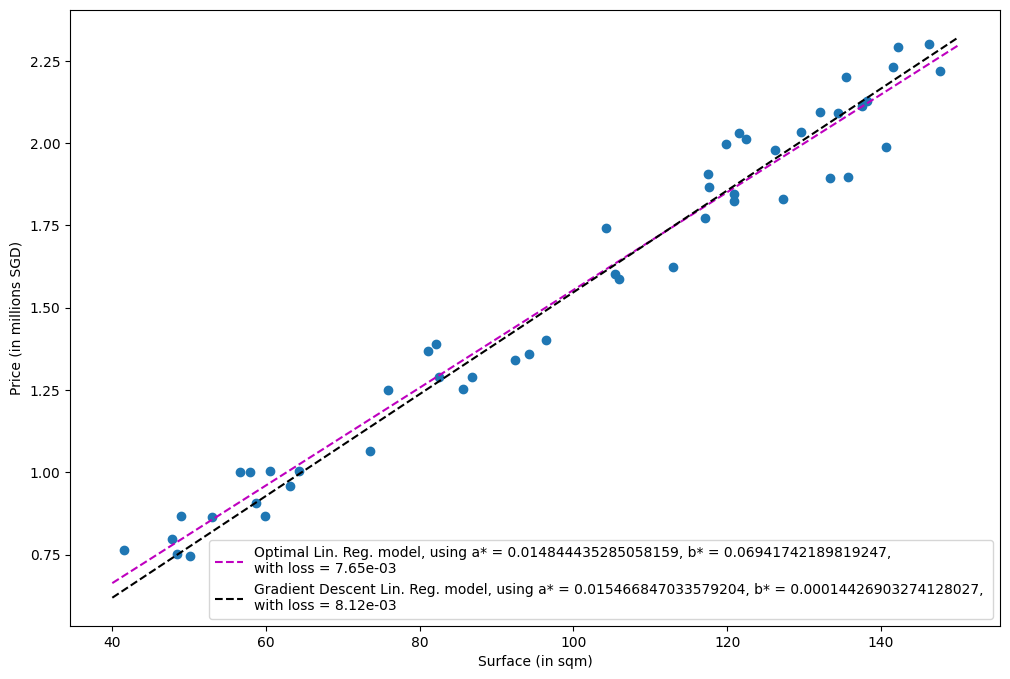

In [12]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Optimal linreg (calculated using the W_star formula)
linreg_dataset1_inputs, linreg_dataset1_outputs = linreg_matplotlib(a_star, b_star, min_surf, max_surf, n_points)
loss1 = loss_mse(a_star, b_star, inputs, outputs)
legend1 = "Optimal Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_star, b_star, loss1)
plt.plot(linreg_dataset1_inputs, linreg_dataset1_outputs, 'm--', label = legend1)

# Gradient Descent linreg
linreg_dataset2_inputs, linreg_dataset2_outputs = linreg_matplotlib(a_gd, b_gd, min_surf, max_surf, n_points)
loss2 = loss_mse(a_gd, b_gd, inputs, outputs)
legend2 = "Gradient Descent Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_gd, b_gd, loss2)
plt.plot(linreg_dataset2_inputs, linreg_dataset2_outputs, 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### Linear Regression using the sklearn library 

In general, when a Linear Regressor is needed, we will import it from the *sklearn* library, instead of implementing it manually.

Refer to the documentation, here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

In [13]:
# Reshape inputs and outputs as a 2D np.array
# (as needed by the Linear Regression object)
sk_inputs = np.array(inputs).reshape(-1, 1)
print(sk_inputs.shape)
print(sk_inputs)
sk_outputs = np.array(outputs)
print(sk_outputs.shape)
print(sk_outputs)

(50, 1)
[[ 86.83]
 [129.6 ]
 [120.89]
 [135.48]
 [ 82.17]
 [147.74]
 [138.25]
 [ 63.07]
 [121.6 ]
 [112.95]
 [137.55]
 [134.38]
 [122.42]
 [135.72]
 [ 60.54]
 [ 75.81]
 [ 81.02]
 [127.31]
 [ 56.62]
 [ 58.69]
 [ 48.93]
 [ 73.57]
 [126.16]
 [ 57.92]
 [ 47.77]
 [117.12]
 [ 59.91]
 [105.88]
 [ 85.68]
 [ 96.49]
 [ 64.27]
 [119.81]
 [133.44]
 [142.18]
 [120.95]
 [ 92.42]
 [ 94.22]
 [105.4 ]
 [ 48.36]
 [ 52.92]
 [146.31]
 [104.17]
 [ 50.17]
 [ 41.5 ]
 [132.06]
 [140.63]
 [117.5 ]
 [ 82.57]
 [117.63]
 [141.56]]
(50,)
[1.290893 2.034977 1.84501  2.201767 1.389632 2.218678 2.127228 0.959054
 2.029469 1.623609 2.111638 2.09194  2.012386 1.89553  1.004256 1.250228
 1.368325 1.830127 1.000719 0.906513 0.867629 1.065907 1.979544 1.001403
 0.796199 1.771816 0.867878 1.587176 1.25434  1.40047  1.002361 1.9972
 1.894479 2.293443 1.823577 1.340533 1.358613 1.602167 0.750759 0.863093
 2.30035  1.741468 0.7448   0.763732 2.093772 1.986868 1.90702  1.289541
 1.86578  2.231851]


In [14]:
# Creating a sklearn Linear Regression model.
# It uses the same analytical formula from earlier, i.e. W^* = (X^T X)^{-1} X^T Y.
reg = LinearRegression().fit(sk_inputs, sk_outputs)
# The coefficients for a* and b* are found using coeff_ and intercept_ respectively.
a_sk = reg.coef_[0]
b_sk = reg.intercept_
print("Optimal a_star value: ", a_star)
print("Value for a_star, found by sklearn: ", a_sk)
print("Optimal b_star value: ", b_star)
print("Value for b_star, found by sklearn: ", b_sk)

Optimal a_star value:  0.014844435285058159
Value for a_star, found by sklearn:  0.014844435285058166
Optimal b_star value:  0.06941742189819247
Value for b_star, found by sklearn:  0.06941742189818956


### Using our model to predict on new unseen data

Eventually, we want to reuse the trained model, to predict the price of a new and unseen appartment with a given surface.

We can use the **predict()** method to do so, and verify that it produces a prediction which is acceptable (by comparing with our theoretical model).

According to our mock dataset formula, the price of this appartment, will most likely fall between 1448248 and 1770081, with an average value of 1609165.

Our predicted price of 1628083 SGD (or equivalently 1.628083126829297 millions of SGD) is therefore not too bad as an estimate.

In [15]:
# We can later use this Linear Regression model, to predict the price of
# a new appartment with surface 105 sqm (price in millions SGD).
new_surf = 105
pred_price = reg.predict(np.array([[new_surf]]))[0]
print(pred_price)

1.628083126829297


In [16]:
avg_price = 14373*new_surf + 100000
min_val = 0.9*avg_price
max_val = 1.1*avg_price
print("Min, max, avg prices: ", [min_val, max_val, avg_price])

Min, max, avg prices:  [1448248.5, 1770081.5000000002, 1609165]


### What's next?

In the next notebook, we will extend the concept of regression to polynomial functions, instead of simple linear ones.